In [2]:
import tensorflow as tf
from gradient_accumulator.GAModelWrapper import GAModelWrapper


######### MODEL #########


base_model = tf.keras.applications.ResNet152V2(include_top=True, 
                                                   weights=None, 
                                                input_shape=(360, 256, 2), 
                                                classes=1,
                                                classifier_activation="sigmoid")
inputs = tf.keras.Input(shape=(360, 256, 2))
x = base_model(inputs, training=False)
model = tf.keras.Model(inputs, x)

model = GAModelWrapper(accum_steps=1, inputs=model.input, outputs=model.output)


model.load_weights("model-255.h5")



/home/viktor/.local/lib/python3.10/site-packages/keras/applications/resnet.py:135: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 2 input channels.
  input_shape = imagenet_utils.obtain_input_shape(


In [19]:
import pandas as pd
df = pd.read_csv("/media/viktor/T7/gravitational-waves-kaggle-2022/datasets/dataset-v1/data.csv")
df_d = pd.read_csv("/media/viktor/T7/gravitational-waves-kaggle-2022/datasets/dataset-v2/data.csv")
df = pd.concat([df, df_d], ignore_index=True)
df

,file,label,depth
0,/media/viktor/T7/gravitational-waves-kaggle-20...,1,14.395424
1,/media/viktor/T7/gravitational-waves-kaggle-20...,0,16.763065
2,/media/viktor/T7/gravitational-waves-kaggle-20...,1,23.607238
3,/media/viktor/T7/gravitational-waves-kaggle-20...,0,21.931825
4,/media/viktor/T7/gravitational-waves-kaggle-20...,0,9.933270
...,...,...,...
163995,/media/viktor/T7/gravitational-waves-kaggle-20...,0,30.794586
163996,/media/viktor/T7/gravitational-waves-kaggle-20...,0,23.115460
163997,/media/viktor/T7/gravitational-waves-kaggle-20...,0,28.559574
163998,/media/viktor/T7/gravitational-waves-kaggle-20...,0,30.402129


In [14]:
df["depth"].max()

32.99977483520588

In [20]:

df = df[df["depth"] > 25].reset_index(drop=True)
# take 256 samples
# df = df.sample(128).reset_index(drop=True)
df

,file,label,depth
0,/media/viktor/T7/gravitational-waves-kaggle-20...,0,26.497585
1,/media/viktor/T7/gravitational-waves-kaggle-20...,1,29.906702
2,/media/viktor/T7/gravitational-waves-kaggle-20...,0,32.403174
3,/media/viktor/T7/gravitational-waves-kaggle-20...,0,28.481253
4,/media/viktor/T7/gravitational-waves-kaggle-20...,0,27.556548
...,...,...,...
58147,/media/viktor/T7/gravitational-waves-kaggle-20...,0,27.278688
58148,/media/viktor/T7/gravitational-waves-kaggle-20...,0,30.794586
58149,/media/viktor/T7/gravitational-waves-kaggle-20...,0,28.559574
58150,/media/viktor/T7/gravitational-waves-kaggle-20...,0,30.402129


In [16]:
# Loop over the dataset and make predictions: save the predictions to a list and create a column in the dataframe
# with the predictions
import numpy as np
from tqdm import tqdm
predictions = []
for i in tqdm(range(len(df))):
    # Get the path to the file
    path = df.iloc[i]["file"]
    # Load the data
    data = np.load(path)
    # Reshape the data
    data = data.reshape(1, 360, 256, 2)
    # Make a prediction
    prediction = model.predict(data, verbose=0)
    # Save the prediction
    predictions.append(prediction[0][0])
    
df["prediction"] = predictions
df

100%|██████████| 128/128 [00:09<00:00, 14.01it/s]


,file,label,depth,prediction
0,/media/viktor/T7/gravitational-waves-kaggle-20...,1,25.837844,0.270335
1,/media/viktor/T7/gravitational-waves-kaggle-20...,0,27.488332,0.316357
2,/media/viktor/T7/gravitational-waves-kaggle-20...,0,30.077414,0.304660
3,/media/viktor/T7/gravitational-waves-kaggle-20...,0,27.527081,0.310181
4,/media/viktor/T7/gravitational-waves-kaggle-20...,1,25.469064,0.429425
...,...,...,...,...
123,/media/viktor/T7/gravitational-waves-kaggle-20...,1,30.349252,0.340049
124,/media/viktor/T7/gravitational-waves-kaggle-20...,1,28.038125,0.249240
125,/media/viktor/T7/gravitational-waves-kaggle-20...,0,27.494513,0.261472
126,/media/viktor/T7/gravitational-waves-kaggle-20...,0,29.036349,0.269196


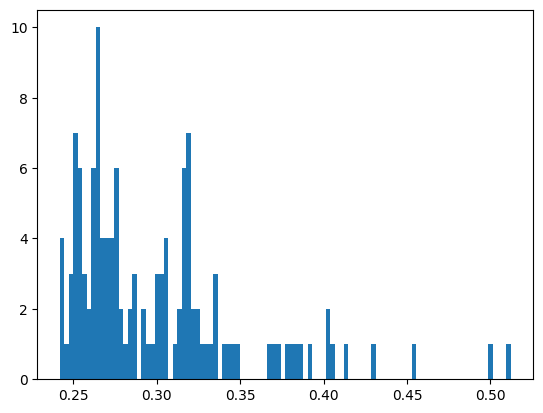

In [17]:
import matplotlib.pyplot as plt
plt.hist(df["prediction"], bins=100);

In [18]:
# calculate auc
from sklearn.metrics import roc_auc_score
roc_auc_score(df["label"], df["prediction"])

0.5408944897454906